<a href="https://colab.research.google.com/github/HromovAndrey/II_Homework_mood_4_part_3/blob/main/%D0%94%D0%97_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [66]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt

Дані про банани

In [67]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/banana_quality.csv')

df['Quality'] = df['Quality'].map({'Good': 1, 'Bad': 0})

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [68]:
df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,0.380309,0.626747,0.680712,0.360975,0.567312,0.671933,0.543416,1
1,0.349951,0.628093,0.485275,0.293682,0.481689,0.646850,0.545720,1
2,0.478460,0.699448,0.572694,0.283811,0.499358,0.716580,0.617337,1
3,0.446465,0.705394,0.595677,0.374028,0.473461,0.633590,0.556625,1
4,0.541672,0.687704,0.458841,0.378242,0.442847,0.579430,0.705908,1


Потрібно на основі інформації про банан спрогнозувати його якість `Quality`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [69]:
class BananaDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data.iloc[index].values.astype('float32')
        y = self.targets.iloc[index].astype('float32')
        return torch.tensor(x), torch.tensor(y)


# Завдання 2
Створіть DataLoader

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df[columns], df['Quality'], test_size=0.2, random_state=42)

train_dataset = BananaDataset(X_train, y_train)
test_dataset = BananaDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


# Завдання 3
Створіть нейромережу

In [71]:
class BananaModel(nn.Module):
    def __init__(self):
        super(BananaModel, self).__init__()
        self.fc1 = nn.Linear(len(columns), 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Завдання 4
Визначте функцію втрат та оптимізатор

In [72]:
model = BananaModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Завдання 5
Натренуйте нейромережу. Візміть невелику кількість епох

In [73]:
def train(model, optimizer, loss_fn, train_loader, val_loader=None, epochs=5, device='cpu'):
    history = {'loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history['loss'].append(epoch_loss)

        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = loss_fn(output.squeeze(), target)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    return history


In [74]:
def plot_history(history, metrics_name=None):
    metrics_name = metrics_name if metrics_name else []

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [75]:
model = BananaModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [76]:
history = train(model, optimizer, criterion, train_loader, test_loader, epochs=5, device='cpu')

Epoch 1/5, Loss: 0.6852, Val Loss: 0.6705
Epoch 2/5, Loss: 0.6286, Val Loss: 0.5697
Epoch 3/5, Loss: 0.5060, Val Loss: 0.4541
Epoch 4/5, Loss: 0.4099, Val Loss: 0.3734
Epoch 5/5, Loss: 0.3586, Val Loss: 0.3407


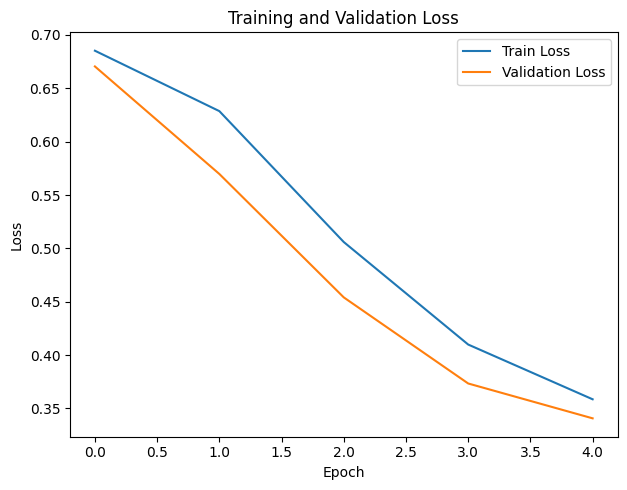

In [77]:
plot_history(history)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [78]:
torch.save(model.state_dict(), 'banana_quality_model.pth')
model.eval()
predictions = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.squeeze().numpy())

predicted_quality = [1 if pred > 0.5 else 0 for pred in predictions]
print(predicted_quality)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 